# Detecting bullying Tweets with PyTorch LSTM + Attention and BERT Transformer Project

This project is about the analysis of tweets about cyberbullying, with the goal of performing a Sentiment Analysis using LSTM w/ Attention and BERT on PyTorch to predict if a tweet is about cyberbullying or not. <br>
In particular, bullying tweets are divided in 4 categories: religion, age, race and gender.<br>
The project is divided in the following sections:

- Data Import
- Text cleaning with custom defined functions
- Naive Bayes baseline model Classifier
- Data preparation for LSTM RNN: Tokenization
- PyTorch LSTM RNN Classifier w/ Attention
- Data preparation for BERT: Tokenization
- PyTorch BERT Classifier
- Results summary

Similar NLP notebooks I made:
- Twitter Sentiment Analysis with BERT + RoBERTa on COVID related tweets:<br>
    https://www.kaggle.com/ludovicocuoghi/twitter-sentiment-analysis-with-bert-roberta

- Twitter Sentiment Analysis with non-labeled tweets about Omicron with using Vader, NLTK, TextBLOB and Flair:<br>
    https://www.kaggle.com/ludovicocuoghi/how-are-people-reacting-to-omicron-on-twitter

# Main results summary:

## Import libraries

In [1]:
#Imports
import os

# Libraries for general purpose
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Text cleaning
import re
import string
import emoji
import nltk
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords

# Data preprocessing
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from langdetect import detect, LangDetectException
import contractions
from nltk.tokenize import word_tokenize

# Naive Bayes
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

# PyTorch LSTM
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Tokenization for LSTM
from collections import Counter
from gensim.models import Word2Vec

# Transformers library for BERT
import transformers
from transformers import BertModel
from transformers import BertTokenizer
from transformers import AdamW, get_linear_schedule_with_warmup
from sklearn.metrics import classification_report, confusion_matrix

import time
import nltk
import demoji
nltk.download('punkt')
nltk.download('wordnet')
# Set seed for reproducibility
import random

c:\Users\romul\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\romul\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\romul\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Data Import

In [2]:
nome_do_arquivo = "cyberbullying_tweets.csv"
# Lê o arquivo CSV
df = pd.read_csv(nome_do_arquivo)

# Realizando algumas configurações iniciais para visualização de dados e processamento de texto
seed_value = 2042
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
torch.cuda.manual_seed_all(seed_value)

# Set style for plots
sns.set_style("whitegrid")
sns.despine()
plt.style.use("seaborn-v0_8-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc("axes", labelweight="bold", labelsize="large", titleweight="bold", titlepad=10)
nltk.download('stopwords')
# Define stop words for text cleaning
stop_words = set(stopwords.words('english'))

# Initialize lemmatizer for text cleaning
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\romul\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<Figure size 640x480 with 0 Axes>

In [3]:
#Renomeando Colunas
df = df.rename(columns={'tweet_text': 'text', 'cyberbullying_type': 'sentiment'})
#Remove Duplicatas
df = df[~df.duplicated()]

# Tweets text deep cleaning

Next, we will define custom functions to clean the texts of the tweets.

In [4]:
# Clean emojis from text

def strip_emoji(text):
    return demoji.replace(text, '')
# Remove punctuations, stopwords, links, mentions and new line characters
def strip_all_entities(text):
    text = re.sub(r'\r|\n', ' ', text.lower())  # Replace newline and carriage return with space, and convert to lowercase
    text = re.sub(r"(?:\@|https?\://)\S+", "", text)  # Remove links and mentions
    text = re.sub(r'[^\x00-\x7f]', '', text)  # Remove non-ASCII characters
    banned_list = string.punctuation
    table = str.maketrans('', '', banned_list)
    text = text.translate(table)
    text = ' '.join(word for word in text.split() if word not in stop_words)
    return text

# Clean hashtags at the end of the sentence, and keep those in the middle of the sentence by removing just the # symbol
def clean_hashtags(tweet):
    # Remove hashtags at the end of the sentence
    new_tweet = re.sub(r'(\s+#[\w-]+)+\s*$', '', tweet).strip()

    # Remove the # symbol from hashtags in the middle of the sentence
    new_tweet = re.sub(r'#([\w-]+)', r'\1', new_tweet).strip()

    return new_tweet

# Filter special characters such as & and $ present in some words
def filter_chars(text):
    return ' '.join('' if ('$' in word) or ('&' in word) else word for word in text.split())

# Remove multiple spaces
def remove_mult_spaces(text):
    return re.sub(r"\s\s+", " ", text)

# Function to check if the text is in English, and return an empty string if it's not
def filter_non_english(text):
    try:
        lang = detect(text)
    except LangDetectException:
        lang = "unknown"
    return text if lang == "en" else ""

# Expand contractions
def expand_contractions(text):
    return contractions.fix(text)

# Remove numbers
def remove_numbers(text):
    return re.sub(r'\d+', '', text)

# Lemmatize words
def lemmatize(text):
    words = word_tokenize(text)
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(lemmatized_words)

# Remove short words
def remove_short_words(text, min_len=2):
    words = text.split()
    long_words = [word for word in words if len(word) >= min_len]
    return ' '.join(long_words)

# Replace elongated words with their base form
def replace_elongated_words(text):
    regex_pattern = r'\b(\w+)((\w)\3{2,})(\w*)\b'
    return re.sub(regex_pattern, r'\1\3\4', text)

# Remove repeated punctuation
def remove_repeated_punctuation(text):
    return re.sub(r'[\?\.\!]+(?=[\?\.\!])', '', text)

# Remove extra whitespace
def remove_extra_whitespace(text):
    return ' '.join(text.split())

def remove_url_shorteners(text):
    return re.sub(r'(?:http[s]?://)?(?:www\.)?(?:bit\.ly|goo\.gl|t\.co|tinyurl\.com|tr\.im|is\.gd|cli\.gs|u\.nu|url\.ie|tiny\.cc|alturl\.com|ow\.ly|bit\.do|adoro\.to)\S+', '', text)

# Remove spaces at the beginning and end of the tweet
def remove_spaces_tweets(tweet):
    return tweet.strip()

# Remove short tweets
def remove_short_tweets(tweet, min_words=3):
    words = tweet.split()
    return tweet if len(words) >= min_words else ""

# Function to call all the cleaning functions in the correct order
def clean_tweet(tweet):
    tweet = strip_emoji(tweet)
    tweet = expand_contractions(tweet)
    tweet = filter_non_english(tweet)
    tweet = strip_all_entities(tweet)
    tweet = clean_hashtags(tweet)
    tweet = filter_chars(tweet)
    tweet = remove_mult_spaces(tweet)
    tweet = remove_numbers(tweet)
    tweet = lemmatize(tweet)
    tweet = remove_short_words(tweet)
    tweet = replace_elongated_words(tweet)
    tweet = remove_repeated_punctuation(tweet)
    tweet = remove_extra_whitespace(tweet)
    tweet = remove_url_shorteners(tweet)
    tweet = remove_spaces_tweets(tweet)
    tweet = remove_short_tweets(tweet)
    tweet = ' '.join(tweet.split())  # Remove multiple spaces between words
    return tweet
    #Limpando Dados



In [5]:
#Limpando Dados
df['text_clean'] = [clean_tweet(tweet) for tweet in df['text']]

In [6]:
df.head()
df.drop_duplicates("text_clean", inplace=True)
df.sentiment.value_counts()

sentiment
religion               7917
age                    7818
ethnicity              7419
gender                 7282
not_cyberbullying      6058
other_cyberbullying    4911
Name: count, dtype: int64

In [7]:
# Mapeamento das classificações para as categorias desejadas
mapping = {
    'religion': 'Bullying',
    'age': 'Bullying',
    'ethnicity': 'Bullying',
    'gender': 'Bullying',
    'not_cyberbullying': 'Não Bullying',
    'other_cyberbullying': 'Bullying'
}
sentiments = ["Bullying","Não Bullying"]

# Aplicando o mapeamento à coluna 'sentiment'
df['sentiment'] = df['sentiment'].map(mapping)

# Verificando as contagens após a transformação
df['sentiment'].value_counts()

sentiment
Bullying        35347
Não Bullying     6058
Name: count, dtype: int64

In [8]:
print(f'There are around {int(df["text_clean"].duplicated().sum())} duplicated tweets, we will remove them.')

There are around 0 duplicated tweets, we will remove them.


In [9]:
df.drop_duplicates("text_clean", inplace=True)

# Tweets length analysis

Now we will define a new dataframe column containing the length of the cleaned tweets in terms of number of words.

In [10]:
df['text_len'] = [len(text.split()) for text in df.text_clean]

C:\Users\romul\AppData\Local\Temp\ipykernel_17724\631618343.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='text_len', data=df[df['text_len']<10], palette='mako')


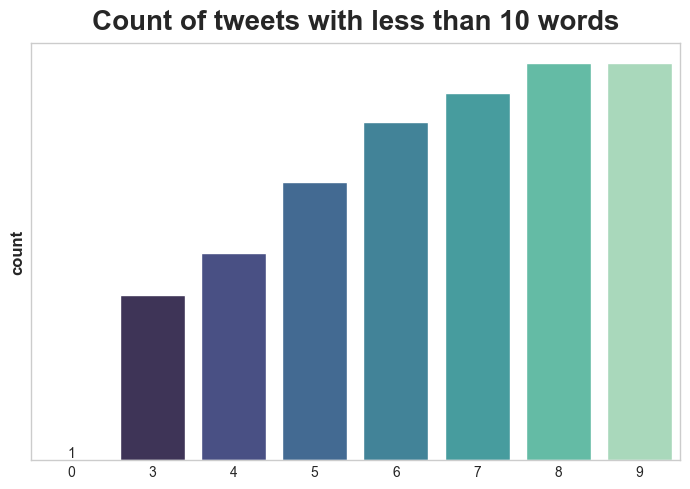

In [11]:
plt.figure(figsize=(7,5))
ax = sns.countplot(x='text_len', data=df[df['text_len']<10], palette='mako')
plt.title('Count of tweets with less than 10 words', fontsize=20)
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

In [12]:
df.sort_values(by=['text_len'], ascending=False)

,text,sentiment,text_clean,text_len
29205,is feminazi an actual word with a denot…\r\n@N...,Bullying,feminazi actual word denot job mean protecting...,372
24516,@NICKIMINAJ: #WutKinda\r\nAt this rate the MKR...,Bullying,wutkinda rate mkr final december mkr haha true...,335
30752,I don't retreat.\r\nyessssssss http://t.co/Td9...,Bullying,retreat yes uh make grownup boruto look lit ba...,233
44035,You so black and white trying to live like a n...,Bullying,black white trying live like nigger pahahahaha...,173
45165,"@hermdiggz: “@tayyoung_: FUCK OBAMA, dumb ass ...",Bullying,fuck obama dumb as nigger bitch ltthis whore s...,151
...,...,...,...,...
31072,@tonycollinet @EverydaySexism The truth? I kn...,Bullying,truth know hate,3
2321,@manufeildel I love that tie!! #MKR,Não Bullying,love tie mkr,3
31110,@ShaofHappiness i love your dog so much.,Bullying,love dog much,3
20774,@Lithobolos @PoliticalAnt @ZaibatsuNews Your m...,Bullying,mantra stupid prof,3


C:\Users\romul\AppData\Local\Temp\ipykernel_17724\2060477503.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='text_len', data=df[(df['text_len']<=1000) & (df['text_len']>10)], palette='Blues_r')


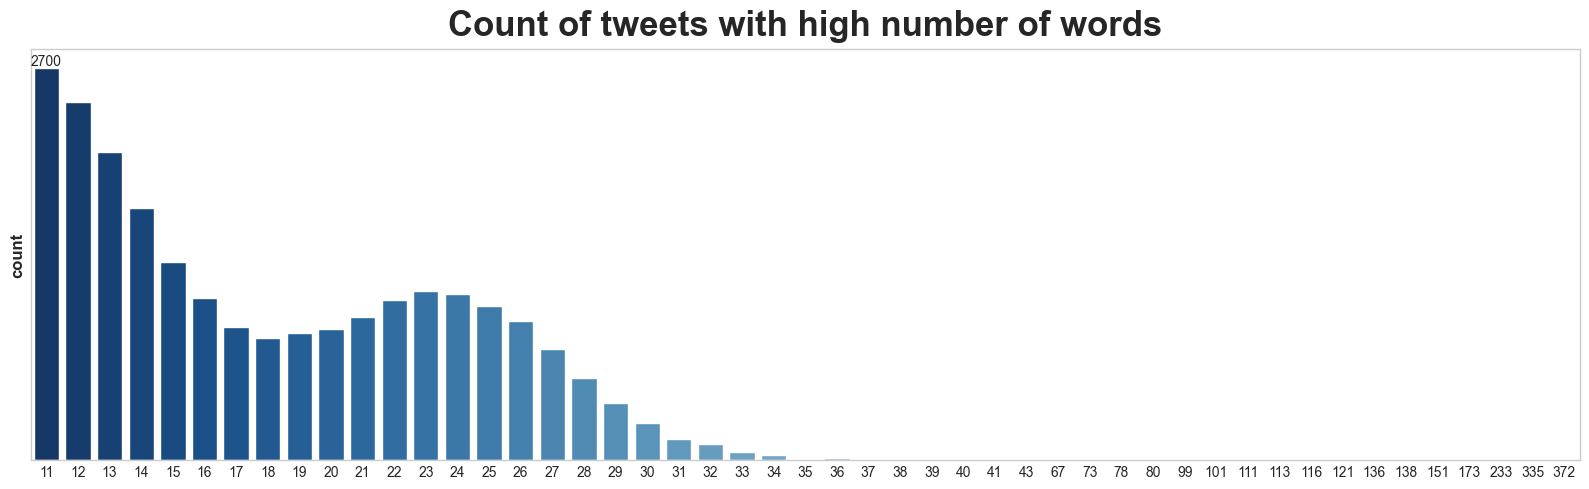

In [13]:
plt.figure(figsize=(16,5))
ax = sns.countplot(x='text_len', data=df[(df['text_len']<=1000) & (df['text_len']>10)], palette='Blues_r')
plt.title('Count of tweets with high number of words', fontsize=25)
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

We also will remove tweets that are too long (with more than 100 words).

In [14]:
df = df[df['text_len'] < df['text_len'].quantile(0.995)]

Then we also get the length of the longest tweet since it will be useful later.

In [15]:
max_len = np.max(df['text_len'])
max_len

31

In [16]:
df.sort_values(by=["text_len"], ascending=False)

,text,sentiment,text_clean,text_len
34374,Sure #MAGAts think that. In poor uneducated #M...,Bullying,sure magats think poor uneducated maga househo...,31
42342,U really gonna act like a lot of people didnt ...,Bullying,really going act like lot people dumb shitman ...,31
46637,Fuck my so called mama for giving birth to the...,Bullying,fuck called mama giving birth hoe amp fuck cal...,31
9910,"Vvery clever, very funny, aged poorly. Ross wa...",Bullying,vvery clever funny aged poorly ross creepy joe...,31
13843,Watching edgy atheist on YouTube complain abou...,Bullying,watching edgy atheist youtube complain thing l...,31
...,...,...,...,...
4836,RT @ChrisWarcraft: @freebsdgirl 10 Standup 20 ...,Não Bullying,rt standup goto,3
4839,@Lithobolos @DixieSportsman @GirlPainting @KLS...,Não Bullying,care said true,3
4866,@kvanh original content. not RT.,Não Bullying,original content rt,3
7127,@AlexJohanson3 @nathanielhadden can tell you w...,Não Bullying,tell home schooled,3


## Sentiment column encoding

The target column will be encoded by ordinal encoding

In [17]:
df['sentiment'] = df['sentiment'].replace({'Bullying':0,'Não Bullying':1})

## Train - Test split

Now we need to split the dataset into a train and test sets.

In [18]:
X = df['text_clean']
y = df['sentiment']
print(y)

0        1
1        1
2        1
3        1
4        1
        ..
47687    0
47688    0
47689    0
47690    0
47691    0
Name: sentiment, Length: 41156, dtype: int64


In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=seed_value)

## Train - Validation split

Moreover, we will further split the training set to extract a validation set, which will be used to monior the accuracy and loss to avoid overfitting during the model training.

In [20]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=seed_value)


In [21]:
(unique, counts) = np.unique(y_train, return_counts=True)
np.asarray((unique, counts)).T

array([[    0, 22464],
       [    1,  3875]], dtype=int64)

The classes are unbalanced, so it could be a good idea to oversample the training set such that all classes have the same count as the most populated one.

# Oversampling of training set

In [22]:
ros = RandomOverSampler()
X_train, y_train = ros.fit_resample(np.array(X_train).reshape(-1, 1), np.array(y_train).reshape(-1, 1));
train_os = pd.DataFrame(list(zip([x[0] for x in X_train], y_train)), columns = ['text_clean', 'sentiment']);

In [23]:
X_train = train_os['text_clean'].values
y_train = train_os['sentiment'].values

In [24]:
(unique, counts) = np.unique(y_train, return_counts=True)
np.asarray((unique, counts)).T

array([[    0, 22464],
       [    1, 22464]], dtype=int64)

# Naive Bayes baseline model

The first algorithm we will implement is Naive Bayes, which will be used as a simple baseline model. In order to use this algorithm, we need first need to preprocess the text data. <br>
First, we will create a bag of words using CountVectorizer.

In [25]:
clf = CountVectorizer()
X_train_cv =  clf.fit_transform(X_train)
X_test_cv = clf.transform(X_test)

Then we apply TF-IFD transformation to associate weigths to the different words based on their frequency (rarer words will be given more importance).

In [26]:
tf_transformer = TfidfTransformer(use_idf=True).fit(X_train_cv)
X_train_tf = tf_transformer.transform(X_train_cv)
X_test_tf = tf_transformer.transform(X_test_cv)

Finally we can instantiate the Naive Bayes model.

In [27]:
nb_clf = MultinomialNB()

In [28]:
nb_clf.fit(X_train_tf, y_train)

MultinomialNB()

In [29]:
nb_pred = nb_clf.predict(X_test_tf)

In [30]:
print('Classification Report for Naive Bayes:\n',classification_report(y_test, nb_pred, target_names=sentiments))

Classification Report for Naive Bayes:
               precision    recall  f1-score   support

    Bullying       0.94      0.89      0.92      7021
Não Bullying       0.52      0.66      0.58      1211

    accuracy                           0.86      8232
   macro avg       0.73      0.78      0.75      8232
weighted avg       0.88      0.86      0.87      8232



In [31]:
def conf_matrix(y, y_pred, title, labels):
    fig, ax =plt.subplots(figsize=(7.5,7.5))
    ax=sns.heatmap(confusion_matrix(y, y_pred), annot=True, cmap="Purples", fmt='g', cbar=False, annot_kws={"size":30})
    plt.title(title, fontsize=25)
    ax.xaxis.set_ticklabels(labels, fontsize=16)
    ax.yaxis.set_ticklabels(labels, fontsize=14.5)
    ax.set_ylabel('Test', fontsize=25)
    ax.set_xlabel('Predicted', fontsize=25)
    plt.show()


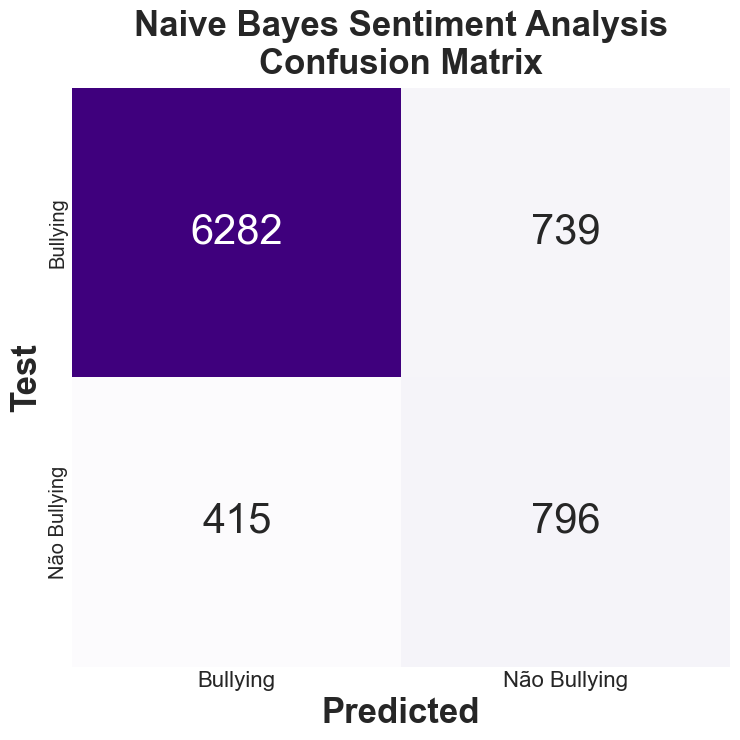

In [32]:
conf_matrix(y_test,nb_pred,'Naive Bayes Sentiment Analysis\nConfusion Matrix', sentiments)

**The performance scores of the algorithm is very good, with an overall accurcy of 87%.<br>
We can observe how the predictions for the more populated classes have very high F1 scores (over 85%), while for the class "non-cyberbullying" the score is much lower (58%).**

*Next we will implement a more complex algorithm to perform the classification, aiming to achieve higher accurcy than the baseline Naive Bayes model.*

# PyTorch LSTM RNN w/ Attention

In this section, we will define a custom Unidirectional and Bidirectional LSTM using PyTorch in order to perform the Sentiment Analysis on the tweets.

## Data preprocessing for LSTM

Similarly to what we did with Naive Bayes, we need to preprocess the data: in particular we will tokenize the sentences with a custom defined function. <br>
The sentences will be converted to lists of number with padding to the max number of words in a sentence.

In [33]:
def Tokenize(column, seq_len):
    ##Create vocabulary of words from column
    corpus = [word for text in column for word in text.split()]
    count_words = Counter(corpus)
    sorted_words = count_words.most_common()
    vocab_to_int = {w:i+1 for i, (w,c) in enumerate(sorted_words)}

    ##Tokenize the columns text using the vocabulary
    text_int = []
    for text in column:
        r = [vocab_to_int[word] for word in text.split()]
        text_int.append(r)
    ##Add padding to tokens
    features = np.zeros((len(text_int), seq_len), dtype = int)
    for i, review in enumerate(text_int):
        if len(review) <= seq_len:
            zeros = list(np.zeros(seq_len - len(review)))
            new = zeros + review
        else:
            new = review[: seq_len]
        features[i, :] = np.array(new)

    return sorted_words, features

In [34]:
vocabulary, tokenized_column = Tokenize(df["text_clean"], max_len)

We can check how each tweet has been tokenized with an example:

In [35]:
df["text_clean"].iloc[0]

'word katandandre food crapilicious mkr'

This sentence is transformed to the vector:

In [36]:
tokenized_column[10]

array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     9,  8157, 16489])

Moreover we can also check the TOP 20 most common words by extracting them from the vocabulary python dictionary we created with the tokenizer.

In [37]:
keys = []
values = []
for key, value in vocabulary[:20]:
    keys.append(key)
    values.append(value)
print(values)

[8900, 5645, 5466, 5393, 5270, 5062, 5049, 4939, 4895, 4791, 4679, 4550, 4063, 3988, 3858, 3571, 3386, 3097, 2929, 2889]


C:\Users\romul\AppData\Local\Temp\ipykernel_17724\2081876966.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=keys, y=values, palette='mako')


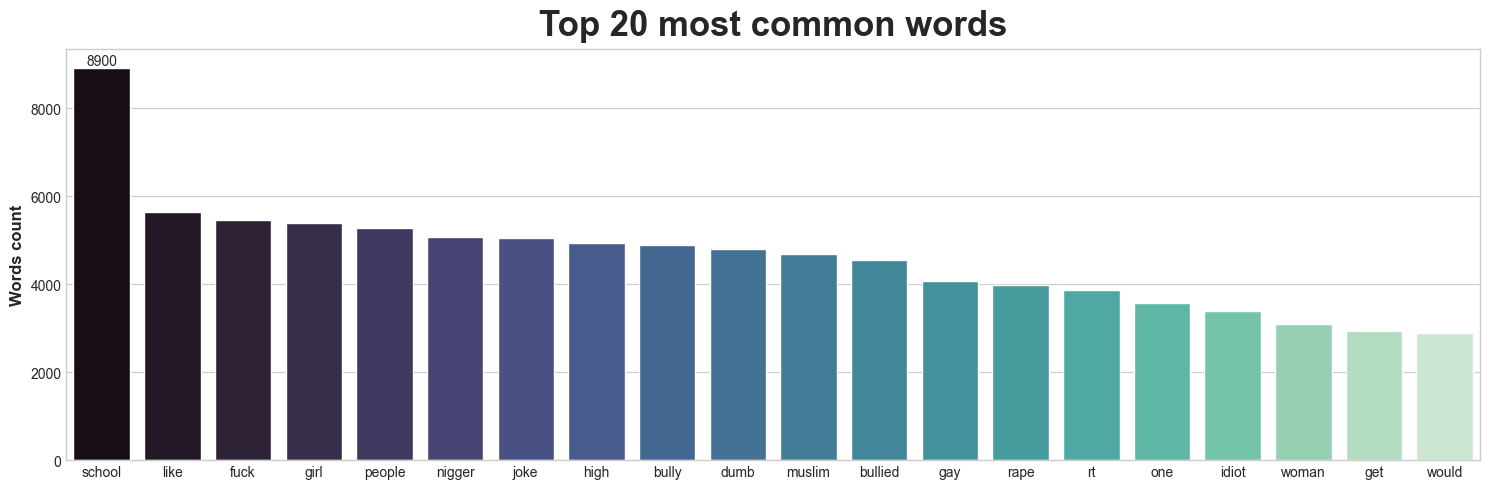

In [38]:
plt.figure(figsize=(15, 5))
ax = sns.barplot(x=keys, y=values, palette='mako')
plt.title('Top 20 most common words', size=25)
ax.bar_label(ax.containers[0])
plt.ylabel("Words count")
plt.show()

# Word Embedding by Word2Vec

Next, we will create a word embedding matrix using the original text tweets and the pre trained model Word2vec.<br>
First, we create a list of words from the X_train vector created before.

In [39]:
Word2vec_train_data = list(map(lambda x: x.split(), X_train))

We set a dimension of the embedding words, which can be seen as the number of featurs of each transformed word.

In [40]:
EMBEDDING_DIM = 200

Then we can instaniate the Word2Vec model by passing the training words and chosen embedding dimension to the imported Word2vec object.

In [41]:
word2vec_model = Word2Vec(Word2vec_train_data, vector_size=EMBEDDING_DIM)

Before defining the embedding matrix, we also need to choose the max number of words. We will extract the number of words from the vocabulary python dictionary we created before.

In [42]:
print(f"Vocabulary size: {len(vocabulary) + 1}")

Vocabulary size: 39771


In [43]:
VOCAB_SIZE = len(vocabulary) + 1 #+1 for the padding

Finally we can define the embedding matrix.

In [44]:
# Define an empty embedding matrix of shape (VOCAB_SIZE, EMBEDDING_DIM)
embedding_matrix = np.zeros((VOCAB_SIZE, EMBEDDING_DIM))

# Fill the embedding matrix with pre-trained values from word2vec
for word, token in vocabulary:
    # Check if the word is present in the word2vec model's vocabulary
    if word in word2vec_model.wv.key_to_index:
        # If the word is present, retrieve its embedding vector and add it to the embedding matrix
        embedding_vector = word2vec_model.wv[word]
        embedding_matrix[token] = embedding_vector

# Print the shape of the embedding matrix
print("Embedding Matrix Shape:", embedding_matrix.shape)

Embedding Matrix Shape: (39771, 200)


## Train - Validation - Test split

Now we will use the tokenized sentences to create a training, validation and test datasets.

In [45]:
X = tokenized_column
y = df['sentiment'].values

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=seed_value)

In [47]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=seed_value)

We can check the balance of the target classes:

In [48]:
(unique, counts) = np.unique(y_train, return_counts=True)
np.asarray((unique, counts)).T

array([[    0, 22464],
       [    1,  3875]], dtype=int64)

And then apply random oversampling on the training set.

In [69]:
ros = RandomOverSampler()
X_train_os, y_train_os = ros.fit_resample(np.array(X_train),np.array(y_train));


In [70]:
print(X_train_os)

[[    0     0     0 ...     6  9659  2104]
 [    0     0     0 ...   105   124   612]
 [    0     0     0 ...   195   820  3144]
 ...
 [    0     0     0 ...   658   464   221]
 [    0     0     0 ...    32 12247 17700]
 [    0     0     0 ...  2370  2328  1596]]


Apply Bag of Words and TF-ID

In [71]:
vectorizer_bow = CountVectorizer()
X_train_bow = vectorizer_bow.fit_transform(X_train_os)
X_valid_bow = vectorizer_bow.transform(X_valid)
X_test_bow = vectorizer_bow.transform(X_test)
from sklearn.feature_extraction.text import TfidfVectorizer
# Convertendo os dados de texto para representações numéricas usando TF-IDF
vectorizer_tfidf = TfidfVectorizer()
X_train_tfidf = vectorizer_tfidf.fit_transform(X_train_os)
X_valid_tfidf = vectorizer_tfidf.transform(X_valid)
X_test_tfidf = vectorizer_tfidf.transform(X_test)


AttributeError: 'numpy.ndarray' object has no attribute 'lower'

In [52]:
(unique, counts) = np.unique(y_train_os, return_counts=True)
np.asarray((unique, counts)).T

array([[    0, 22464],
       [    1, 22464]], dtype=int64)

## PyTorch datasets and dataloaders

The three sets will be transformed to tensor datasets and dataloaders so we can extract the data in batches for the LSTM training, validation and testing.

In [53]:
# Convertendo para Tensores do PyTorch
train_data_bow = TensorDataset(torch.from_numpy(X_train_bow.toarray()), torch.from_numpy(y_train_os))
test_data_bow = TensorDataset(torch.from_numpy(X_test_bow.toarray()), torch.from_numpy(y_test))
valid_data_bow = TensorDataset(torch.from_numpy(X_valid_bow.toarray()), torch.from_numpy(y_valid))

train_data_tfidf = TensorDataset(torch.from_numpy(X_train_tfidf.toarray()), torch.from_numpy(y_train_os))
test_data_tfidf = TensorDataset(torch.from_numpy(X_test_tfidf.toarray()), torch.from_numpy(y_test))
valid_data_tfidf = TensorDataset(torch.from_numpy(X_valid_tfidf.toarray()), torch.from_numpy(y_valid))

In [54]:
BATCH_SIZE = 32

In [55]:
train_loader_bow = DataLoader(train_data_bow, shuffle=True, batch_size=BATCH_SIZE, drop_last=True)
valid_loader_bow = DataLoader(valid_data_bow, shuffle=False, batch_size=BATCH_SIZE, drop_last=True)
test_loader_bow = DataLoader(test_data_bow, shuffle=False, batch_size=BATCH_SIZE, drop_last=True)

train_loader_tfidf = DataLoader(train_data_tfidf, shuffle=True, batch_size=BATCH_SIZE, drop_last=True)
valid_loader_tfidf = DataLoader(valid_data_tfidf, shuffle=False, batch_size=BATCH_SIZE, drop_last=True)
test_loader_tfidf = DataLoader(test_data_tfidf, shuffle=False, batch_size=BATCH_SIZE, drop_last=True)

# PyTorch LSTM modeling with Attention Layer

In this chapter we implement two Python classes: Attention and LSTM_Sentiment_Classifier.

This LSTM model with attention allows us to better handle the complexities of language understanding by giving more importance to the relevant parts of our text data. This enhances the model's ability to understand context and thereby, improves the performance of our Sentiment Analysis task.

In [56]:
class Attention(nn.Module):
    def __init__(self, hidden_dim, is_bidirectional):
        super(Attention, self).__init__()
        self.is_bidirectional = is_bidirectional
        # The attention linear layer which transforms the input data to the hidden space
        self.attn = nn.Linear(hidden_dim * (4 if is_bidirectional else 2), hidden_dim * (2 if is_bidirectional else 1))
        # The linear layer that calculates the attention scores
        self.v = nn.Linear(hidden_dim * (2 if is_bidirectional else 1), 1, bias=False)

    def forward(self, hidden, encoder_outputs):
        seq_len = encoder_outputs.size(1)
        # Concatenate the last two hidden states in case of a bidirectional LSTM
        if self.is_bidirectional:
            hidden = torch.cat((hidden[-2], hidden[-1]), dim=-1)
        else:
            hidden = hidden[-1]
        # Repeat the hidden state across the sequence length
        hidden_repeated = hidden.unsqueeze(1).repeat(1, seq_len, 1)
        # Calculate attention weights
        attn_weights = torch.tanh(self.attn(torch.cat((hidden_repeated, encoder_outputs), dim=2)))
        # Compute attention scores
        attn_weights = self.v(attn_weights).squeeze(2)
        # Apply softmax to get valid probabilities
        return nn.functional.softmax(attn_weights, dim=1)


class LSTM_Sentiment_Classifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_classes, lstm_layers, dropout, is_bidirectional):
        super(LSTM_Sentiment_Classifier, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = lstm_layers
        self.is_bidirectional = is_bidirectional

        # The Embedding layer that converts input words to embeddings
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        # LSTM layer which processes the embeddings
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, lstm_layers, batch_first=True, bidirectional=is_bidirectional)
        # Attention layer to compute the context vector
        self.attention = Attention(hidden_dim, is_bidirectional)
        # Fully connected layer which classifies the context vector into classes
        self.fc = nn.Linear(hidden_dim * (2 if is_bidirectional else 1), num_classes)
        # Apply LogSoftmax to outputs for numerical stability
        self.softmax = nn.LogSoftmax(dim=1)
        # Dropout layer for regularisation
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, hidden):
        # Transform words to embeddings
        embedded = self.embedding(x)
        # Pass embeddings to LSTM
        out, hidden = self.lstm(embedded, hidden)
        # Calculate attention weights
        attn_weights = self.attention(hidden[0], out)
        # Calculate context vector by taking the weighted sum of LSTM outputs
        context = attn_weights.unsqueeze(1).bmm(out).squeeze(1)
        # Classify the context vector
        out = self.softmax(self.fc(context))
        return out, hidden

    def init_hidden(self, batch_size):
        # Factor determines the size of hidden states depending on bidirectionality
        factor = 2 if self.is_bidirectional else 1
        # Initial hidden and cell states are zero
        h0 = torch.zeros(self.num_layers * factor, batch_size, self.hidden_dim).to(DEVICE)
        c0 = torch.zeros(self.num_layers * factor, batch_size, self.hidden_dim).to(DEVICE)
        return (h0, c0)

In [57]:
NUM_CLASSES = 5 #We are dealing with a multiclass classification of 5 classes
HIDDEN_DIM = 100 #number of neurons of the internal state (internal neural network in the LSTM)
LSTM_LAYERS = 1 #Number of stacked LSTM layers

IS_BIDIRECTIONAL = False # Set this to False for unidirectional LSTM, and True for bidirectional LSTM

LR = 4e-4 #Learning rate
DROPOUT = 0.5 #LSTM Dropout
EPOCHS = 10 #Number of training epoch

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

model = LSTM_Sentiment_Classifier(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM, NUM_CLASSES, LSTM_LAYERS, DROPOUT, IS_BIDIRECTIONAL)

model = model.to(DEVICE)

# Initialize the embedding layer with the previously defined embedding matrix
model.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
# Allow the embedding matrix to be fine-tuned to better adapt to our dataset and get higher accuracy
model.embedding.weight.requires_grad = True

# Set up the criterion (loss function)
criterion = nn.NLLLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay = 5e-6)

print(model)

LSTM_Sentiment_Classifier(
  (embedding): Embedding(39771, 200)
  (lstm): LSTM(200, 100, batch_first=True)
  (attention): Attention(
    (attn): Linear(in_features=200, out_features=100, bias=True)
    (v): Linear(in_features=100, out_features=1, bias=False)
  )
  (fc): Linear(in_features=100, out_features=5, bias=True)
  (softmax): LogSoftmax(dim=1)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [63]:
print(len(valid_loader_bow))
print(len(train_loader_bow))

205
1404


# LSTM Training loop

Now we will define a custom training loop, where we include an early stopping functionality, and save only the best models in terms of validation accuracy.

BOW

In [59]:
total_step1 = len(train_loader_bow)
total_step_val1 = len(valid_loader_bow)

early_stopping_patience = 4
early_stopping_counter = 0

valid_acc_max = 0 # Initialize best accuracy top 0

for e in range(EPOCHS):
    print("primeiro FOR")
    #lists to host the train and validation losses of every batch for each epoch
    train_loss, valid_loss  = [], []
    #lists to host the train and validation accuracy of every batch for each epoch
    train_acc, valid_acc  = [], []

    #lists to host the train and validation predictions of every batch for each epoch
    y_train_list, y_val_list = [], []

    #initalize number of total and correctly classified texts during training and validation
    correct, correct_val = 0, 0
    total, total_val = 0, 0
    running_loss, running_loss_val = 0, 0


    ####TRAINING LOOP####

    model.train()

    for inputs, labels in train_loader_bow:
        print("2 FOR")
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE) #load features and targets in device
     
        h = model.init_hidden(labels.size(0))

        model.zero_grad() #reset gradients

        output, h = model(inputs,h) #get output and hidden states from LSTM network

        loss = criterion(output, labels)
        loss.backward()

        running_loss += loss.item()

        optimizer.step()

        y_pred_train = torch.argmax(output, dim=1) #get tensor of predicted values on the training set
        y_train_list.extend(y_pred_train.squeeze().tolist()) #transform tensor to list and the values to the list

        correct += torch.sum(y_pred_train==labels).item() #count correctly classified texts per batch
        total += labels.size(0) #count total texts per batch
        print("2 FOR FInal")
    train_loss.append(running_loss / total_step)
    train_acc.append(100 * correct / total)
    print("primeiro FOR final")
    ####VALIDATION LOOP####

    with torch.no_grad():

        model.eval()

        for inputs, labels in valid_loader:
            print("3 FOR")
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

            val_h = model.init_hidden(labels.size(0))

            output, val_h = model(inputs, val_h)

            val_loss = criterion(output, labels)
            running_loss_val += val_loss.item()

            y_pred_val = torch.argmax(output, dim=1)
            y_val_list.extend(y_pred_val.squeeze().tolist())

            correct_val += torch.sum(y_pred_val==labels).item()
            total_val += labels.size(0)

        valid_loss.append(running_loss_val / total_step_val)
        valid_acc.append(100 * correct_val / total_val)

    #Save model if validation accuracy increases
    if np.mean(valid_acc) >= valid_acc_max:
        torch.save(model.state_dict(), './state_dict_bow.pt')
        print(f'Epoch {e+1}:Validation accuracy increased ({valid_acc_max:.6f} --> {np.mean(valid_acc):.6f}).  Saving model ...')
        valid_acc_max = np.mean(valid_acc)
        early_stopping_counter=0 #reset counter if validation accuracy increases
    else:
        print(f'Epoch {e+1}:Validation accuracy did not increase')
        early_stopping_counter+=1 #increase counter if validation accuracy does not increase

    if early_stopping_counter > early_stopping_patience:
        print('Early stopped at epoch :', e+1)
        break

    print(f'\tTrain_loss : {np.mean(train_loss):.4f} Val_loss : {np.mean(valid_loss):.4f}')
    print(f'\tTrain_acc : {np.mean(train_acc):.3f}% Val_acc : {np.mean(valid_acc):.3f}%')

primeiro FOR
2 FOR
2 FOR FInal
2 FOR
2 FOR FInal
2 FOR
2 FOR FInal
2 FOR
2 FOR FInal
2 FOR
2 FOR FInal
2 FOR
2 FOR FInal
2 FOR
2 FOR FInal
2 FOR
2 FOR FInal
2 FOR
2 FOR FInal
2 FOR
2 FOR FInal
2 FOR
2 FOR FInal
2 FOR
2 FOR FInal
2 FOR
2 FOR FInal
2 FOR
2 FOR FInal
2 FOR
2 FOR FInal
2 FOR
2 FOR FInal
2 FOR
2 FOR FInal
2 FOR
2 FOR FInal
2 FOR
2 FOR FInal
2 FOR
2 FOR FInal
2 FOR
2 FOR FInal
2 FOR
2 FOR FInal
2 FOR
2 FOR FInal
2 FOR
2 FOR FInal
2 FOR
2 FOR FInal
2 FOR
2 FOR FInal
2 FOR
2 FOR FInal
2 FOR
2 FOR FInal
2 FOR
2 FOR FInal
2 FOR
2 FOR FInal
2 FOR
2 FOR FInal
2 FOR
2 FOR FInal
2 FOR
2 FOR FInal
2 FOR
2 FOR FInal
2 FOR
2 FOR FInal
2 FOR
2 FOR FInal
2 FOR
2 FOR FInal
2 FOR
2 FOR FInal
2 FOR
2 FOR FInal
2 FOR
2 FOR FInal
2 FOR
2 FOR FInal
2 FOR
2 FOR FInal
2 FOR
2 FOR FInal
2 FOR
2 FOR FInal
2 FOR
2 FOR FInal
2 FOR
2 FOR FInal
2 FOR
2 FOR FInal
2 FOR


KeyboardInterrupt: 

TF-IDF

In [ ]:


total_step = len(train_loader_tfidf)
total_step_val = len(valid_loader_tfidf)

early_stopping_patience = 4
early_stopping_counter = 0

valid_acc_max = 0 # Initialize best accuracy top 0

for e in range(EPOCHS):

    #lists to host the train and validation losses of every batch for each epoch
    train_loss, valid_loss  = [], []
    #lists to host the train and validation accuracy of every batch for each epoch
    train_acc, valid_acc  = [], []

    #lists to host the train and validation predictions of every batch for each epoch
    y_train_list, y_val_list = [], []

    #initalize number of total and correctly classified texts during training and validation
    correct, correct_val = 0, 0
    total, total_val = 0, 0
    running_loss, running_loss_val = 0, 0


    ####TRAINING LOOP####

    model.train()

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE) #load features and targets in device

        h = model.init_hidden(labels.size(0))

        model.zero_grad() #reset gradients

        output, h = model(inputs,h) #get output and hidden states from LSTM network

        loss = criterion(output, labels)
        loss.backward()

        running_loss += loss.item()

        optimizer.step()

        y_pred_train = torch.argmax(output, dim=1) #get tensor of predicted values on the training set
        y_train_list.extend(y_pred_train.squeeze().tolist()) #transform tensor to list and the values to the list

        correct += torch.sum(y_pred_train==labels).item() #count correctly classified texts per batch
        total += labels.size(0) #count total texts per batch

    train_loss.append(running_loss / total_step)
    train_acc.append(100 * correct / total)

    ####VALIDATION LOOP####

    with torch.no_grad():

        model.eval()

        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

            val_h = model.init_hidden(labels.size(0))

            output, val_h = model(inputs, val_h)

            val_loss = criterion(output, labels)
            running_loss_val += val_loss.item()

            y_pred_val = torch.argmax(output, dim=1)
            y_val_list.extend(y_pred_val.squeeze().tolist())

            correct_val += torch.sum(y_pred_val==labels).item()
            total_val += labels.size(0)

        valid_loss.append(running_loss_val / total_step_val)
        valid_acc.append(100 * correct_val / total_val)

    #Save model if validation accuracy increases
    if np.mean(valid_acc) >= valid_acc_max:
        torch.save(model.state_dict(), './state_dict_tf.pt')
        print(f'Epoch {e+1}:Validation accuracy increased ({valid_acc_max:.6f} --> {np.mean(valid_acc):.6f}).  Saving model ...')
        valid_acc_max = np.mean(valid_acc)
        early_stopping_counter=0 #reset counter if validation accuracy increases
    else:
        print(f'Epoch {e+1}:Validation accuracy did not increase')
        early_stopping_counter+=1 #increase counter if validation accuracy does not increase

    if early_stopping_counter > early_stopping_patience:
        print('Early stopped at epoch :', e+1)
        break

    print(f'\tTrain_loss : {np.mean(train_loss):.4f} Val_loss : {np.mean(valid_loss):.4f}')
    print(f'\tTrain_acc : {np.mean(train_acc):.3f}% Val_acc : {np.mean(valid_acc):.3f}%')

In [ ]:
# Loading the best model
model.load_state_dict(torch.load('./state_dict_bow.pt'))

In [ ]:
model.load_state_dict(torch.load('./state_dict_tf.pt'))

# LSTM Testing

In [ ]:
def evaluate_model(model, test_loader):
    model.eval()
    y_pred_list = []
    y_test_list = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            test_h = model.init_hidden(labels.size(0))

            output, val_h = model(inputs, test_h)
            y_pred_test = torch.argmax(output, dim=1)
            y_pred_list.extend(y_pred_test.squeeze().tolist())
            y_test_list.extend(labels.squeeze().tolist())

    return y_pred_list, y_test_list

y_pred_list, y_test_list = evaluate_model(model, test_loader)

In [ ]:
# Avaliação do modelo TF-IDF
y_pred_list_tfidf, y_test_list_tfidf = evaluate_model(model_tfidf, test_loader_tfidf)
print('Classification Report for TF-IDF Bi-LSTM:\n', classification_report(y_test_list_tfidf, y_pred_list_tfidf, target_names=sentiments))


In [ ]:
conf_matrix(y_test_list_tfidf, y_pred_list_tfidf, 'PyTorch Bi-LSTM Sentiment Analysis (TF-IDF)\nConfusion Matrix', sentiments)

In [ ]:
# Avaliação do modelo BoW
model_bow.eval()
y_pred_list_bow, y_test_list_bow = evaluate_model(model_bow, test_loader_bow)


In [ ]:

print('Classification Report for BoW Bi-LSTM:\n', classification_report(y_test_list_bow, y_pred_list_bow, target_names=sentiments))
conf_matrix(y_test_list_bow, y_pred_list_bow, 'PyTorch Bi-LSTM Sentiment Analysis (BoW)\nConfusion Matrix', sentiments)

**The performance scores of the algorithm are very high, with an overall accuracy of 93%.**<br>
**In particular, the F1 scores for the more populated classes are over 95%**

# BERT Classification

In this section, we will load a pre trained BERT model from the Hugging Face library and fine tune it for our classification task.

First, we need to split the dataset into train - validation - test again since we need to tokenize the sentences differently from before (Naive Bayes and LSTM).

## Train - Validation - Test split

In [ ]:
X = df['text_clean'].values
y = df['sentiment'].values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=seed_value)

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=seed_value)

As seen before, we oversample the text to the majority class.

In [ ]:
ros = RandomOverSampler()
X_train_os, y_train_os = ros.fit_resample(np.array(X_train).reshape(-1,1),np.array(y_train).reshape(-1,1))

In [ ]:
X_train_os = X_train_os.flatten()
y_train_os = y_train_os.flatten()

In [ ]:
(unique, counts) = np.unique(y_train_os, return_counts=True)
np.asarray((unique, counts)).T

# BERT Tokenization

Since we need to tokenize the tweets (get "input ids" and "attention masks") for BERT, we load the specific BERT tokenizer from the Hugging Face library.

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Then we define a custom tokenizer function using the loaded tokenizer.

In [ ]:
def bert_tokenizer(data):
    input_ids = []
    attention_masks = []
    for sent in data:
        encoded_sent = tokenizer.encode_plus(
            text=sent,
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]` special tokens
            max_length=MAX_LEN,             # Choose max length to truncate/pad
            pad_to_max_length=True,         # Pad sentence to max length
            return_attention_mask=True      # Return attention mask
            )
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

Since we need to specify the length of the longest tokenized sentence, we tokenize the train tweets using the "encode" method of the original BERT tokenizer and check the longest sentence.

In [ ]:
# Tokenize train tweets
encoded_tweets = [tokenizer.encode(sent, add_special_tokens=True) for sent in X_train]

# Find the longest tokenized tweet
max_len = max([len(sent) for sent in encoded_tweets])
print('Max length: ', max_len)

We can choose the max length as 128.

In [ ]:
MAX_LEN = 128

Then we can tokenize the train, validation and test tweets using the custom define tokenizer.

In [ ]:
train_inputs, train_masks = bert_tokenizer(X_train_os)
val_inputs, val_masks = bert_tokenizer(X_valid)
test_inputs, test_masks = bert_tokenizer(X_test)

## Data preprocessing for PyTorch BERT model

Since we are using the BERT model built on PyTorch, we need to convert the arrays to pytorch tensors and create dataloaders for the data.

In [ ]:
# Convert target columns to pytorch tensors format
train_labels = torch.from_numpy(y_train_os)
val_labels = torch.from_numpy(y_valid)
test_labels = torch.from_numpy(y_test)

## Dataloaders

To fine-tune the BERT model, the original authors recommend a batch size of 16 or 32.

In [ ]:
batch_size = 32

In [ ]:
# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

# Create the DataLoader for our test set
test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

# BERT Modeling

Now we can create a custom BERT classifier class, including the original BERT model (made of transformer layers) and additional Dense layers to perform the desired classification task.

In [ ]:
class Bert_Classifier(nn.Module):
    def __init__(self, freeze_bert=False):
        super(Bert_Classifier, self).__init__()
        # Specify hidden size of BERT, hidden size of the classifier, and number of labels
        n_input = 768
        n_hidden = 50
        n_output = 5

        # Instantiate BERT model
        self.bert = BertModel.from_pretrained('bert-base-uncased')

        # Instantiate the classifier (a fully connected layer followed by a ReLU activation and another fully connected layer)
        self.classifier = nn.Sequential(
            nn.Linear(n_input, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_output)
        )

        # Freeze the BERT model weights if freeze_bert is True (useful for feature extraction without fine-tuning)
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False

    def forward(self, input_ids, attention_mask):
        # Feed input data (input_ids and attention_mask) to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)

        # Extract the last hidden state of the `[CLS]` token from the BERT output (useful for classification tasks)
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed the extracted hidden state to the classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits

Moreover, since we want to define a learning rate scheduler, we define a custom "initalize_model" function as follows.

In [ ]:
# Function for initializing the BERT Classifier model, optimizer, and learning rate scheduler
def initialize_model(epochs=4):
    # Instantiate Bert Classifier
    bert_classifier = Bert_Classifier(freeze_bert=False)

    bert_classifier.to(device)

    # Set up optimizer
    optimizer = AdamW(bert_classifier.parameters(),
                      lr=5e-5,    # learning rate, set to default value
                      eps=1e-8    # decay, set to default value
                      )

    # Calculate total number of training steps
    total_steps = len(train_dataloader) * epochs

    # Define the learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)
    return bert_classifier, optimizer, scheduler

We also specify the use of GPU if present (highly recommended for the fine tuning)

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
EPOCHS=2

And then we intialize the BERT model calling the "initialize_model" function we defined.

In [ ]:
bert_classifier, optimizer, scheduler = initialize_model(epochs=EPOCHS)

# BERT Training

After defining the custom BERT classifier model, we are ready to start the training.

In [ ]:
# Define Cross entropy Loss function for the multiclass classification task
loss_fn = nn.CrossEntropyLoss()
import time
import torch
import torch.nn as nn
import numpy as np

def bert_train(model, train_dataloader, val_dataloader=None, epochs=4, evaluation=False):
    print("Start training...\n")

    # Move the model to the appropriate device outside the epoch loop
    model.to(device)

    optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)  # Example, adjust as needed
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)  # Example, adjust as needed

    for epoch_i in range(epochs):
        print("-" * 10)
        print(f"Epoch: {epoch_i + 1}/{epochs}")
        print("-" * 10)
        print("-" * 38)
        print(f"{'BATCH NO.':^7} | {'TRAIN LOSS':^12} | {'ELAPSED (s)':^9}")
        print("-" * 38)

        t0_epoch, t0_batch = time.time(), time.time()
        total_loss, batch_loss, batch_counts = 0, 0, 0

        model.train()

        for step, batch in enumerate(train_dataloader):
            batch_counts += 1
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

            model.zero_grad()
            logits = model(b_input_ids, b_attn_mask)
            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()

            if (step % 200 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                time_elapsed = time.time() - t0_batch
                print(f"{step:^9} | {batch_loss / batch_counts:^12.6f} | {time_elapsed:^9.2f}")
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        avg_train_loss = total_loss / len(train_dataloader)

        if evaluation and val_dataloader is not None:
            model.eval()
            val_accuracy = []
            val_loss = []

            with torch.no_grad():
                for batch in val_dataloader:
                    batch_input_ids, batch_attention_mask, batch_labels = tuple(t.to(device) for t in batch)
                    logits = model(batch_input_ids, batch_attention_mask)
                    loss = loss_fn(logits, batch_labels)
                    val_loss.append(loss.item())
                    preds = torch.argmax(logits, dim=1).flatten()
                    accuracy = (preds == batch_labels).cpu().numpy().mean() * 100
                    val_accuracy.append(accuracy)

            val_loss = np.mean(val_loss)
            val_accuracy = np.mean(val_accuracy)

            time_elapsed = time.time() - t0_epoch
            print("-" * 61)
            print(f"{'AVG TRAIN LOSS':^12} | {'VAL LOSS':^10} | {'VAL ACCURACY (%)':^9} | {'ELAPSED (s)':^9}")
            print("-" * 61)
            print(f"{avg_train_loss:^14.6f} | {val_loss:^10.6f} | {val_accuracy:^17.2f} | {time_elapsed:^9.2f}")
            print("-" * 61)
            print("\n")
        else:
            time_elapsed = time.time() - t0_epoch
            print("-" * 38)
            print(f"{'AVG TRAIN LOSS':^12} | {'ELAPSED (s)':^9}")
            print("-" * 38)
            print(f"{avg_train_loss:^14.6f} | {time_elapsed:^9.2f}")
            print("-" * 38)
            print("\n")

    print("Training complete!")


In [ ]:
bert_train(bert_classifier, train_dataloader, val_dataloader, epochs=EPOCHS)

# BERT Prediction

Now we define a function similar to the model "evaluation", where we feed to the model the test data instead of the validation data.

In [ ]:
def bert_predict(model, test_dataloader):

    # Define empty list to host the predictions
    preds_list = []

    # Put the model into evaluation mode
    model.eval()

    for batch in test_dataloader:
        batch_input_ids, batch_attention_mask = tuple(t.to(device) for t in batch)[:2]

        # Avoid gradient calculation of tensors by using "no_grad()" method
        with torch.no_grad():
            logit = model(batch_input_ids, batch_attention_mask)

        # Get index of highest logit
        pred = torch.argmax(logit,dim=1).cpu().numpy()
        # Append predicted class to list
        preds_list.extend(pred)

    return preds_list

Then we can call the defined function and get the class predictions of the test data.

In [ ]:
bert_preds = bert_predict(bert_classifier, test_dataloader)

In [ ]:
print('Classification Report for BERT :\n', classification_report(y_test, bert_preds, target_names=sentiments))

In [ ]:
conf_matrix(y_test, bert_preds,' BERT Sentiment Analysis\nConfusion Matrix', sentiments)

**The performance scores of BERT Classifier are quite high and higher than those achieved using the LSTM model, with an overall accuracy around 95% and F1 scores well over 95%.**<br>

Thank your for checking out my notebook! Let me know if you have comments or if you want me to check out your work! :)